# Solution to A6 - P280

## Problem 1

Enter the polynomial as a dictionary:

In [1]:
linear = {('q0', 'q0'): 0.33, ('q5', 'q5'): 0.33, ('q1', 'q1'): -0.33, ('q4', 'q4'): -0.33}
quadratic = {('q0', 'q4'): 0.66, ('q1', 'q4'): 0.66, ('q1', 'q5'): 0.66, ('q0', 'q5'): -1}
Q = dict(linear)
Q.update(quadratic)

Use the sampler `ExactSolver` from `dimod` to evaluate all possibilities:

In [4]:
from dimod import *

In [3]:
sampleset = dimod.ExactSolver().sample_qubo(Q)
print(sampleset)

   q0 q1 q4 q5 energy num_oc.
2   1  0  0  1  -0.34       1
7   0  1  0  0  -0.33       1
15  0  0  1  0  -0.33       1
5   1  1  0  1  -0.01       1
13  1  0  1  1  -0.01       1
0   0  0  0  0    0.0       1
6   1  1  0  0    0.0       1
8   0  1  1  0    0.0       1
12  0  0  1  1    0.0       1
1   1  0  0  0   0.33       1
3   0  0  0  1   0.33       1
4   0  1  0  1   0.66       1
14  1  0  1  0   0.66       1
10  1  1  1  1   0.98       1
9   1  1  1  0   0.99       1
11  0  1  1  1   0.99       1
['BINARY', 16 rows, 16 samples, 4 variables]


There are 3 states with lowest energy -0.33: $1001$, $0100$, $0010$. In all three $q0=q5$, each corresponding to one of the 3 possible 3-SAT solutions: $b=1$, $a=1$, $c=1$. 

## Problem 2

part (a), run the exact solver dimod:

In [41]:
from dimod.generators import combinations
from dimod import BinaryQuadraticModel

Initialize the BQM.

In [42]:
bqm_csp= BinaryQuadraticModel('BINARY')

Use a loop with the function combinations to implement the relevant BQM. 

In [43]:
for i in range(8):
    bqm_csp.update(combinations([str(i),str(i+1),str(i+2)], 1))

Now find the best solutions using brute force:

In [44]:
brute_force_set = dimod.ExactSolver().sample(bqm_csp)
for (sample, energy, num) in brute_force_set.data():
    if energy==0: print(sample)

{'0': 0, '1': 1, '2': 0, '3': 0, '4': 1, '5': 0, '6': 0, '7': 1, '8': 0, '9': 0}
{'0': 0, '1': 0, '2': 1, '3': 0, '4': 0, '5': 1, '6': 0, '7': 0, '8': 1, '9': 0}
{'0': 1, '1': 0, '2': 0, '3': 1, '4': 0, '5': 0, '6': 1, '7': 0, '8': 0, '9': 1}


(b) Run in the QPU.

In [35]:
from dwave.system import DWaveSampler, EmbeddingComposite
sampler = EmbeddingComposite(DWaveSampler())
dwave_set = sampler.sample(bqm_csp, num_reads=1000)

In [45]:
fl=False
for sample, energy, num_occurrences, chain_break_fraction in dwave_set.data():
    if energy==0: print(sample)
    fl=True
if not(fl): print("Failed to satisfy. Try again.")

{'0': 0, '1': 1, '2': 0, '3': 0, '4': 1, '5': 0, '6': 0, '7': 1, '8': 0, '9': 0}
{'0': 0, '1': 0, '2': 1, '3': 0, '4': 0, '5': 1, '6': 0, '7': 0, '8': 1, '9': 0}
{'0': 1, '1': 0, '2': 0, '3': 1, '4': 0, '5': 0, '6': 1, '7': 0, '8': 0, '9': 1}


As we can see, the QPU found all three soultions to the CSP problem. 

## Problem 3

Generate the graph:

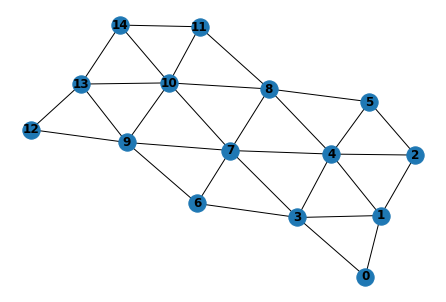

In [93]:
import networkx as nx
import matplotlib.pyplot as plt 
G=nx.triangular_lattice_graph(4, 4) 
G=nx.convert_node_labels_to_integers(G) 
nx.draw(G,with_labels=True,font_weight='bold')

Let's solve the problem in the QPU:

In [95]:
import dwave_networkx as dnx
sampler = EmbeddingComposite(DWaveSampler())
print(dnx.min_vertex_cover(G, sampler))

[0, 2, 3, 4, 6, 8, 9, 10, 13, 14]


This turns out not to be the minimum set. Let's try again:

In [96]:
print(dnx.min_vertex_cover(G, sampler))

[1, 3, 4, 5, 7, 9, 10, 11, 13]


I think this is the minimum number of vertices, 9. This shows that the solution is always approximate, there is no guarantee that it is satisfied (and while it is easy to check that the set is a cover, it's quite hard to check that the set is the minimum one). 

Let's use `ExactSolver` to check that the minimum set has 9 vertices:

In [98]:
sampler = ExactSolver()
print(dnx.min_vertex_cover(G, sampler))

[1, 3, 4, 5, 7, 9, 10, 11, 13]


Indeed, the QPU got the right answer. 

## Problem 4

First note that it is not possible to color the graph with two colors, because each node has three neighbors. The solution with three colors follows closely the map coloring [example](https://docs.ocean.dwavesys.com/en/latest/examples/map_coloring.html#map-coloring) in the Ocean documentation. However, note that below we extract the list of nodes and neighbors as integers, so we need to convert them to strings when defining them as variables, see `str(nod)`, `str(v)`, etc below. 

In [105]:
nods = nx.nodes(G)
neighs = nx.edges(G)

In [110]:
def not_both_1(v, u):
    return not (v and u)

# Valid configurations for the constraint that each node select a single color
one_color_configurations = {(0, 0, 1), (0, 1, 0), (1, 0, 0)}
colors = len(one_color_configurations)

# Create a binary constraint satisfaction problem
csp = dwavebinarycsp.ConstraintSatisfactionProblem(dwavebinarycsp.BINARY)

# Add constraint that each node (province) select a single color
for nod in nods:
    variables = [str(nod)+str(i) for i in range(colors)]
    csp.add_constraint(one_color_configurations, variables)

# Add constraint that each pair of nodes with a shared edge not both select one color
for neigh in neighs:
    v, u = neigh
    for i in range(colors):
        variables = [str(v)+str(i), str(u)+str(i)]
        csp.add_constraint(not_both_1, variables)

In [111]:
bqm = dwavebinarycsp.stitch(csp)

In [112]:
sampler = EmbeddingComposite(DWaveSampler())       
sampleset = sampler.sample(bqm, num_reads=1000)

# Check that a good solution was found
sample = sampleset.first.sample
if not csp.check(sample):
    print("Failed to color map. Try sampling again.")
else:
    print(sample)

{'00': 0, '01': 1, '02': 0, '10': 1, '100': 0, '101': 1, '102': 0, '11': 0, '110': 1, '111': 0, '112': 0, '12': 0, '120': 0, '121': 1, '122': 0, '130': 1, '131': 0, '132': 0, '140': 0, '141': 0, '142': 1, '20': 0, '21': 0, '22': 1, '30': 0, '31': 0, '32': 1, '40': 0, '41': 1, '42': 0, '50': 1, '51': 0, '52': 0, '60': 0, '61': 1, '62': 0, '70': 1, '71': 0, '72': 0, '80': 0, '81': 0, '82': 1, '90': 0, '91': 0, '92': 1}


In [115]:
def plot_map(sample):
    G2 = nx.Graph()
    G2.add_nodes_from(nods)
    G2.add_edges_from(neighs)
# Translate from binary to integer color representation
    color_map = {}
    for nod in nods:
          for i in range(colors):
            if sample[str(nod)+str(i)]:
                color_map[nod] = i
# Plot the sample with color-coded nodes
    node_colors = [color_map.get(node) for node in G2.nodes()]
    nx.draw(G2, with_labels=True, node_color=node_colors, node_size=3000, cmap=plt.cm.rainbow)
    plt.show()

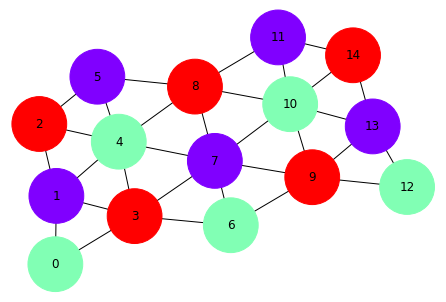

In [116]:
plot_map(sample) 